In [1]:
#%matplotlib notebook
%matplotlib inline

import ComunicationClasses.Database_collector

import matplotlib.pyplot as plt

import pandas as pd

from math import pi
from numpy import array
from scipy.optimize import minimize
from DataAnalysisClasses.SensorCurve3D import SensorCurve3D
from DataAnalysisClasses.AngleCalculator import AngleCalculator
from DataAnalysisClasses.KalmanFilter import KalmanFilter
from DataAnalysisClasses.BiasCompensator import BiasCompensator
from ComunicationClasses.Database_collector import Database_collector
from DataAnalysisClasses.GeometryConstants import GeometryVectors

plt.ion()

# Get IMU data from database

## Create DB client and test connection

In [2]:
print('Testing connection')
db_host_address = 'localhost'
print('Server IP: ' + db_host_address)
db_client = Database_collector()
if not db_client.check_connection():
    raise RuntimeError('No dataframe connection')
else:
    print('Connection ok')

Testing connection
Server IP: localhost
Connection ok


In [3]:
print('List of databases:')
print(db_client.get_db_list())

print('List of measurements:')
print(db_client.get_measurements_list('scan_sensor_test'))

List of databases:
['scan_sensor_test']
List of measurements:
['ISM_330_raw', 'MPU_9255_raw', 'scanner_raw']


### Get raw data from inertial sensors

In [4]:
#time_start=1644518082462
#time_stop = 1644518106858
time_start=1652530355
time_stop = 1652530381
data_raw_ISM = db_client.get_measurement_data('scan_sensor_test', 'ISM_330_raw', time_start, time_stop).dropna()
data_raw_MPU = db_client.get_measurement_data('scan_sensor_test', 'MPU_9255_raw', time_start, time_stop).dropna()

### Compensate initial bias

In [5]:
bias_ISM = BiasCompensator('ISM_330', 'linear')
bias_MPU = BiasCompensator('MPU_9255', 'linear')
# Use first seconds to get gyro bias|
bias_ISM.set_gyro_const_bias(2000, data_raw_ISM)
bias_MPU.set_gyro_const_bias(2000, data_raw_MPU)

In [6]:
# Apply bias compensation
data_bias_ISM = bias_ISM.apply_bias(data_raw_ISM)
data_bias_MPU = bias_MPU.apply_bias(data_raw_MPU)

### Rotate vectors of IMU data

In [7]:
device_geometry = GeometryVectors()
data_rot_ISM = device_geometry.rotation_apply_vect(data_bias_ISM,['acc_X_b','acc_Y_b','acc_Z_b'],'ISM_330')
data_rot_ISM = device_geometry.rotation_apply_vect(data_rot_ISM,['gyro_X_b','gyro_Y_b','gyro_Z_b'],'ISM_330')
data_rot_MPU = device_geometry.rotation_apply_vect(data_bias_MPU,['acc_X_b','acc_Y_b','acc_Z_b'],'MPU_9255')
data_rot_MPU = device_geometry.rotation_apply_vect(data_rot_MPU,['gyro_X_b','gyro_Y_b','gyro_Z_b'],'MPU_9255')
# drop unneded columns
data_rot_ISM.drop(columns=['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z'], inplace=True)
data_rot_MPU.drop(columns=['acc_X','acc_Y','acc_Z','gyro_X','gyro_Y','gyro_Z'], inplace=True)

print(data_rot_ISM.describe())

print(data_bias_ISM.describe())

print(data_rot_MPU.describe())

print(data_bias_MPU.describe())

### Show two sensors data against each other

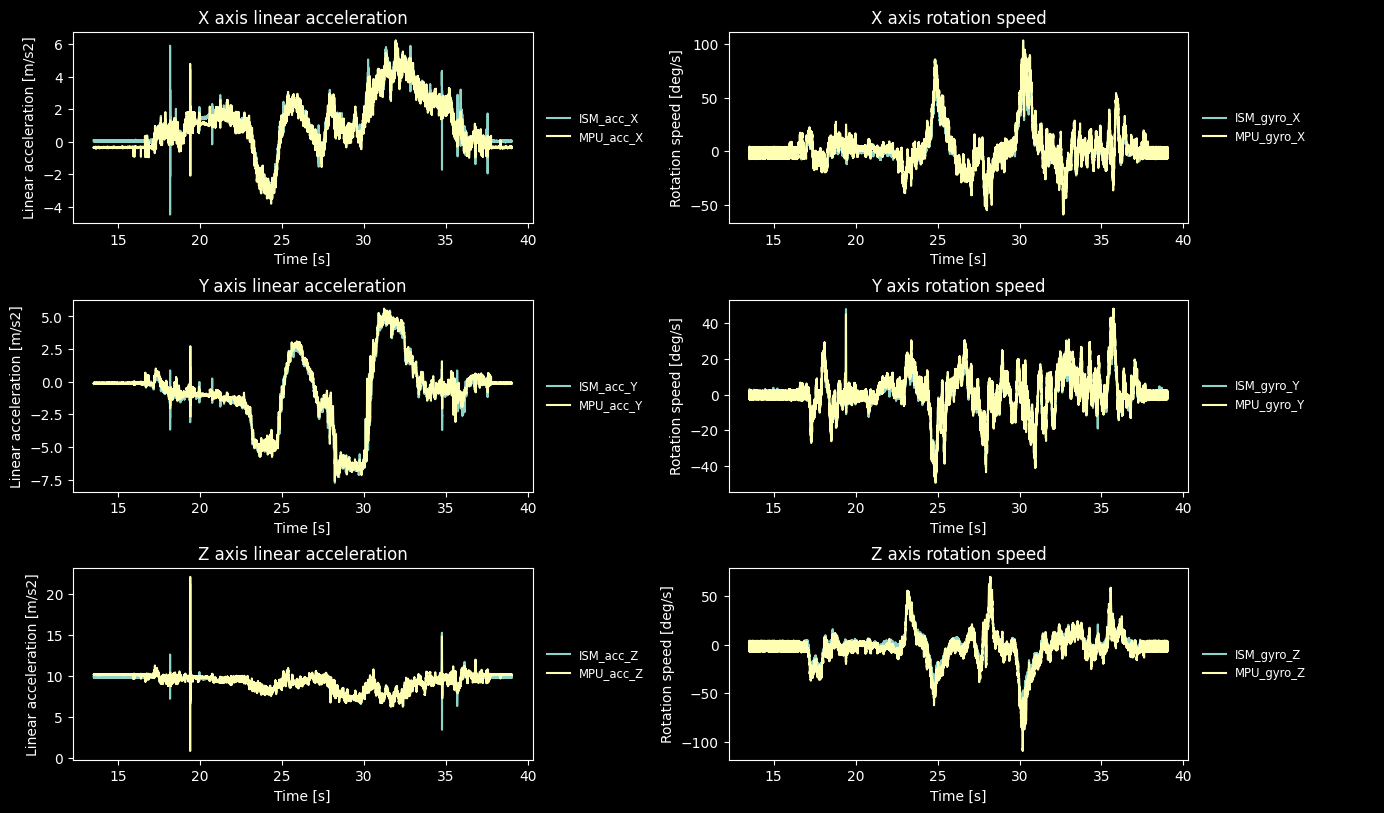

In [8]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_X_b'], label='ISM_acc_X')
axis[0, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_X_b'], label='MPU_acc_X')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_X_b'], label='ISM_gyro_X')
axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_X_b'], label='MPU_gyro_X')
axis[0, 2].set_title('X axis rotation speed')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Y_b'], label='ISM_acc_Y')
axis[1, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Y_b'], label='MPU_acc_Y')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Y_b'], label='ISM_gyro_Y')
axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Y_b'], label='MPU_gyro_Y')
axis[1, 2].set_title('Y axis rotation speed')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Z_b'], label='ISM_acc_Z')
axis[2, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Z_b'], label='MPU_acc_Z')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Z_b'], label='ISM_gyro_Z')
axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Z_b'], label='MPU_gyro_Z')
axis[2, 2].set_title('Z axis rotation speed')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Calculate acceleration vector in new point (holding only translated data)

In [9]:
# Calculate angular speed derivative from 3 consecutive samples

def derivative(df_in,column_name):
    df_temp = df_in[[column_name]].rolling(window=301, center=True, win_type="gaussian").mean(std=60)
    df_temp['prev'] = df_temp[column_name].shift(1)
    df_temp['next'] = df_temp[column_name].shift(-1)
    #df_temp['prev'] = df_in[column_name].shift(1)
    #df_temp['next'] = df_in[column_name].shift(-1)
    #print(df_temp.head())
    df_in[column_name+'_der']=((df_temp['next']-df_temp['prev'])/2)*1000
    
derivative(data_rot_ISM,'gyro_X_b')
derivative(data_rot_ISM,'gyro_Y_b')
derivative(data_rot_ISM,'gyro_Z_b')
derivative(data_rot_MPU,'gyro_X_b')
derivative(data_rot_MPU,'gyro_Y_b')
derivative(data_rot_MPU,'gyro_Z_b')

data_rot_ISM.fillna(0.0, inplace=True)
data_rot_MPU.fillna(0.0, inplace=True)
#print(data_rot_ISM.head())
#data_rot_ISM['mean_acc_Z_b'].rolling(window=3, center = True).apply(moving_derivative, raw=True)
#data_rot_MPU.rolling(window=3).apply(mad, raw=True)

In [10]:
data_rot_ISM.to_csv('ism_test.csv')

### Show derivative lowpass filter frame

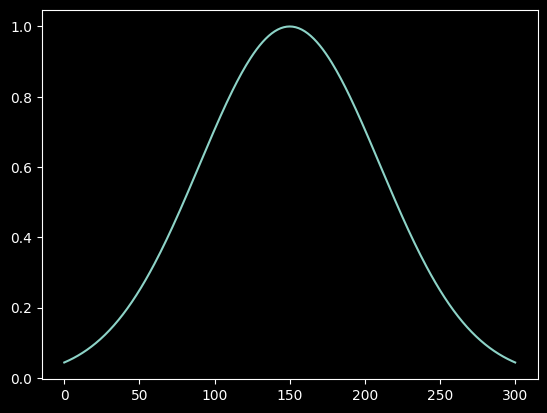

In [11]:
from scipy import signal
window = signal.windows.gaussian(301, std=60)
ax1 = plt.figure().add_subplot()
ax1.plot(window)

### Show rotation speed derivatives

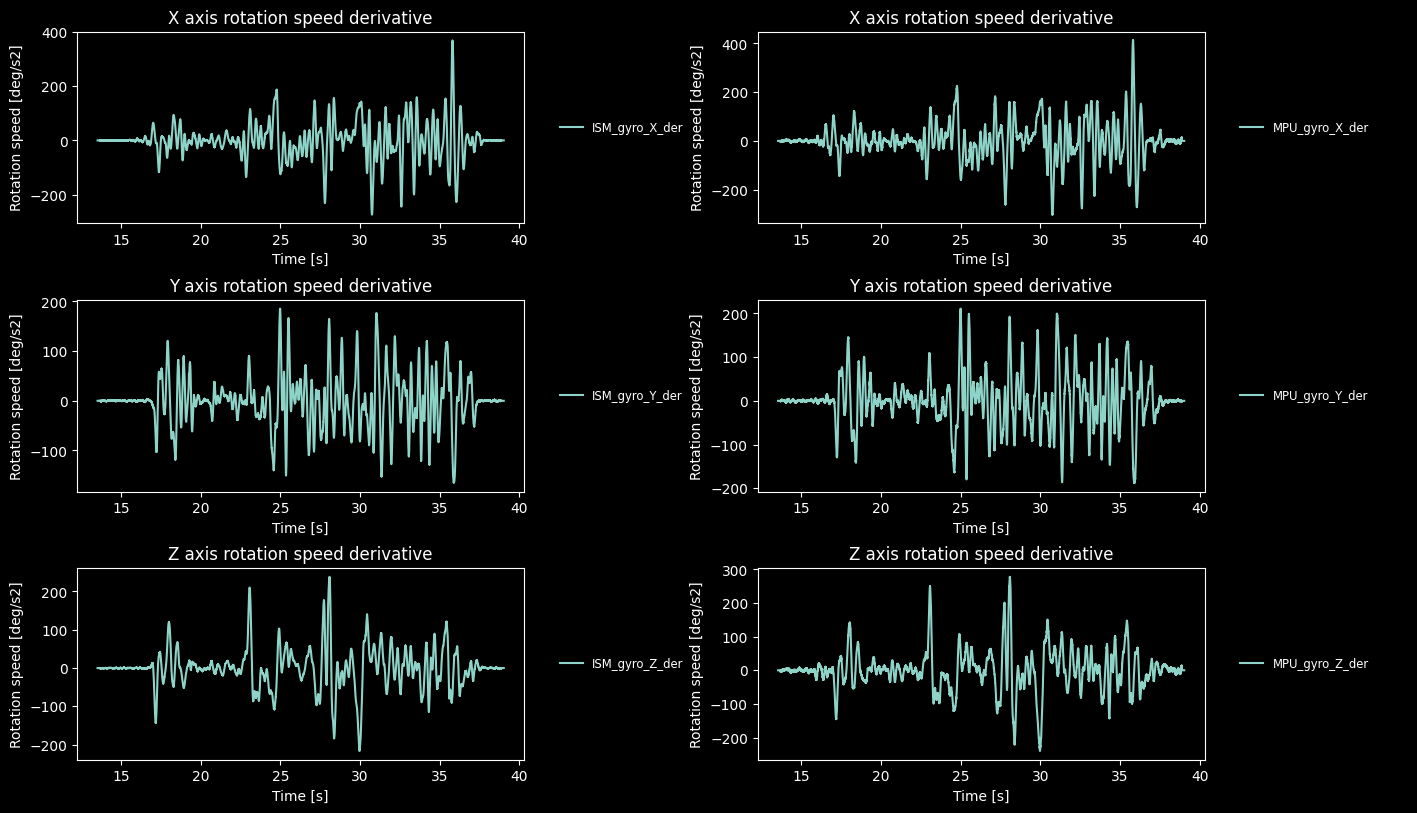

In [12]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_X_b_der'], label='ISM_gyro_X_der')
axis[0, 0].set_title('X axis rotation speed derivative')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot

axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_X_b_der'], label='MPU_gyro_X_der')
axis[0, 2].set_title('X axis rotation speed derivative')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Y_b_der'], label='ISM_gyro_Y_der')
axis[1, 0].set_title('Y axis rotation speed derivative')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot

axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Y_b_der'], label='MPU_gyro_Y_der')
axis[1, 2].set_title('Y axis rotation speed derivative')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Z_b_der'], label='ISM_gyro_Z_der')
axis[2, 0].set_title('Z axis rotation speed derivative')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot

axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Z_b_der'], label='MPU_gyro_Z_der')
axis[2, 2].set_title('Z axis rotation speed derivative')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=1, 
                    top=0.97, 
                    wspace=0.1, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Translate acceleration to scanner zero point

In [13]:
# Translate acceleration to scanner zero point
data_trans_ISM=device_geometry.translate_acceleration_vect(df_in=data_rot_ISM, 
                                                      sensor='ISM_330', 
                                                      acc_names=['acc_X_b','acc_Y_b','acc_Z_b'], 
                                                      gyro_names=['gyro_X_b','gyro_Y_b','gyro_Z_b'], 
                                                      gyro_der_names=['gyro_X_b_der','gyro_Y_b_der','gyro_Z_b_der'], 
                                                      output_names=['acc_X_t','acc_Y_t','acc_Z_t'], 
                                                      ang_unit='deg')
#data_trans_ISM.drop(['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b','mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'])

data_trans_MPU=device_geometry.translate_acceleration_vect(df_in=data_rot_MPU, 
                                                      sensor='MPU_9255', 
                                                      acc_names=['acc_X_b','acc_Y_b','acc_Z_b'], 
                                                      gyro_names=['gyro_X_b','gyro_Y_b','gyro_Z_b'], 
                                                      gyro_der_names=['gyro_X_b_der','gyro_Y_b_der','gyro_Z_b_der'], 
                                                      output_names=['acc_X_t','acc_Y_t','acc_Z_t'], 
                                                      ang_unit='deg')
#data_trans_MPU.drop(['mean_acc_X_b','mean_acc_Y_b','mean_acc_Z_b','mean_gyro_X_b_der','mean_gyro_Y_b_der','mean_gyro_Z_b_der'])

In [14]:
data_trans_ISM.describe()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
count,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000
mean,26.277403,1.214452,-0.861446,9.228796,-0.055662,-0.342125,0.295634,-0.002848,0.000436,-0.002455,1.199024,-0.875990,9.214698
std,7.359338,1.578936,2.544511,0.895318,16.366647,9.672283,14.428516,67.605995,52.145456,52.546305,1.559231,2.608644,0.907779
min,13.531879,-4.477244,-7.741448,3.415029,-56.250878,-40.378602,-87.046306,-273.436367,-165.152093,-216.627147,-4.579593,-7.846003,3.174163
25%,19.904450,0.053583,-1.456405,8.806205,-7.052182,-3.686810,-2.092998,-23.120633,-22.210601,-17.222913,0.053955,-1.478998,8.767581
50%,26.277489,1.029082,-0.517860,9.565248,-0.556298,-0.069968,0.340779,-0.078400,0.000000,0.000000,0.993226,-0.491710,9.552491
75%,32.650365,2.073549,-0.075054,9.819601,2.058042,3.756173,5.200703,22.715070,18.908739,16.666197,2.050817,-0.082571,9.822184
max,39.023436,6.226728,5.451547,21.252374,80.244077,48.030821,64.559936,368.529182,185.529071,238.202354,5.866487,5.399296,21.169651


In [15]:
data_trans_MPU.describe()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
count,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000,25493.000000
mean,26.277403,0.960286,-0.762204,9.289740,2.839477,0.923662,-3.484927,-0.020934,-0.017329,-0.021486,0.917310,-0.803166,9.250557
std,7.359339,1.648786,2.551800,0.956526,19.015003,11.446494,16.876104,77.530441,60.265684,60.617089,1.626257,2.721230,1.038602
min,13.531433,-3.807862,-7.607118,0.820492,-59.372702,-49.546527,-109.758737,-302.398694,-187.663001,-240.117743,-3.644311,-8.427937,0.710883
25%,19.904549,-0.333044,-1.302788,8.805695,-5.531289,-2.957063,-7.452019,-27.274822,-25.378233,-22.640026,-0.328725,-1.369265,8.696325
50%,26.277332,0.802191,-0.383746,9.555227,0.981124,0.840873,-1.909020,-0.508041,0.000000,0.000000,0.787422,-0.331766,9.541688
75%,32.650355,1.902755,0.006165,10.074122,7.072865,6.278828,2.991162,28.045723,22.065796,20.510677,1.805596,0.074587,10.103962
max,39.023271,6.219946,5.595295,22.102430,103.340478,48.250346,69.808913,412.439412,211.044927,277.884389,5.783179,6.238976,22.039142


### Show translated accelerations compared to previous point

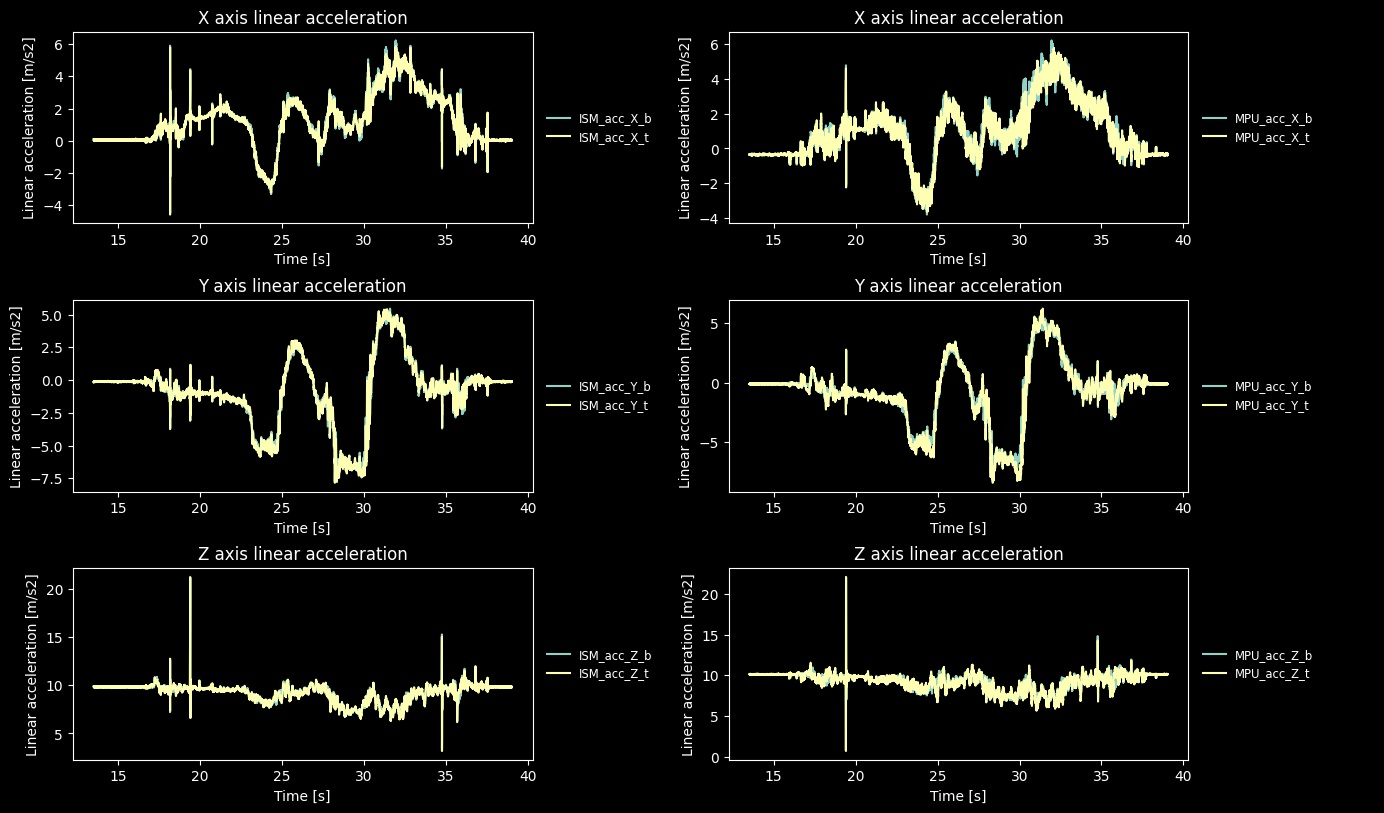

In [16]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_X_b'], label='ISM_acc_X_b')
axis[0, 0].plot(data_trans_ISM['time_rel'], data_trans_ISM['acc_X_t'], label='ISM_acc_X_t')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_X_b'], label='MPU_acc_X_b')
axis[0, 2].plot(data_trans_MPU['time_rel'], data_trans_MPU['acc_X_t'], label='MPU_acc_X_t')
axis[0, 2].set_title('X axis linear acceleration')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Y_b'], label='ISM_acc_Y_b')
axis[1, 0].plot(data_trans_ISM['time_rel'], data_trans_ISM['acc_Y_t'], label='ISM_acc_Y_t')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Y_b'], label='MPU_acc_Y_b')
axis[1, 2].plot(data_trans_MPU['time_rel'], data_trans_MPU['acc_Y_t'], label='MPU_acc_Y_t')
axis[1, 2].set_title('Y axis linear acceleration')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Z_b'], label='ISM_acc_Z_b')
axis[2, 0].plot(data_trans_ISM['time_rel'], data_trans_ISM['acc_Z_t'], label='ISM_acc_Z_t')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Z_b'], label='MPU_acc_Z_b')
axis[2, 2].plot(data_trans_MPU['time_rel'], data_trans_MPU['acc_Z_t'], label='MPU_acc_Z_t')
axis[2, 2].set_title('Z axis linear acceleration')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

### Join two sensors data in single point

In [17]:
data_trans_ISM.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2022-05-14 12:12:35.508000+00:00,13.531879,0.093721,-0.119979,9.873893,-0.006981,-0.064882,2.660115,0.0,0.0,0.0,0.093503,-0.120202,9.873887
2022-05-14 12:12:35.509000+00:00,13.532488,0.031603,-0.130733,9.850028,-0.388451,-0.370057,0.241597,0.0,0.0,0.0,0.031598,-0.130738,9.850014
2022-05-14 12:12:35.510000+00:00,13.533402,0.054061,-0.114722,9.808982,0.768165,0.014464,0.566609,0.0,0.0,0.0,0.054065,-0.114750,9.808977
2022-05-14 12:12:35.511000+00:00,13.533955,0.060273,-0.115200,9.797527,4.234962,2.284972,3.453572,0.0,0.0,0.0,0.060493,-0.115578,9.797507
2022-05-14 12:12:35.512000+00:00,13.535877,0.012489,-0.139097,9.814232,-0.006981,3.047911,0.737507,0.0,0.0,0.0,0.012186,-0.139045,9.814015


In [18]:
# Join two sensors data
ISM_weight = 100
MPU_weight = 1

# drop starting and ending rows with only one sensor 
start = max([data_trans_ISM.index[0],data_trans_MPU.index[0]])
end = min([data_trans_ISM.index[-1],data_trans_MPU.index[-1]])

#data_joined = (pd.concat((data_trans_ISM*ISM_weight, data_trans_MPU*MPU_weight), axis=1).mean(axis=1)/(ISM_weight+MPU_weight))#[start:end]
data_joined = pd.concat((data_trans_ISM.loc[start:end] * ISM_weight, data_trans_MPU.loc[start:end] * MPU_weight))#.mean(axis=0)#, axis=1)#.mean(axis=1)
data_joined=data_joined.groupby(data_joined.index).sum()/(ISM_weight + MPU_weight)

In [19]:
data_joined.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2022-05-14 12:12:35.508000+00:00,13.531875,0.089285,-0.119950,9.876359,-0.006232,-0.045017,2.637666,0.0,0.0,0.0,0.089066,-0.120171,9.876351
2022-05-14 12:12:35.509000+00:00,13.532486,0.027907,-0.130572,9.852641,-0.351149,-0.390757,0.274374,0.0,0.0,0.0,0.027893,-0.130602,9.852618
2022-05-14 12:12:35.510000+00:00,13.533402,0.050379,-0.114619,9.811907,0.780198,0.010682,0.581282,0.0,0.0,0.0,0.050383,-0.114652,9.811902
2022-05-14 12:12:35.511000+00:00,13.533961,0.056403,-0.115084,9.800704,4.176922,2.256466,3.404554,0.0,0.0,0.0,0.056622,-0.115460,9.800685
2022-05-14 12:12:35.512000+00:00,13.535873,0.008902,-0.138862,9.817268,-0.081406,3.039733,0.658493,0.0,0.0,0.0,0.008590,-0.138897,9.817039


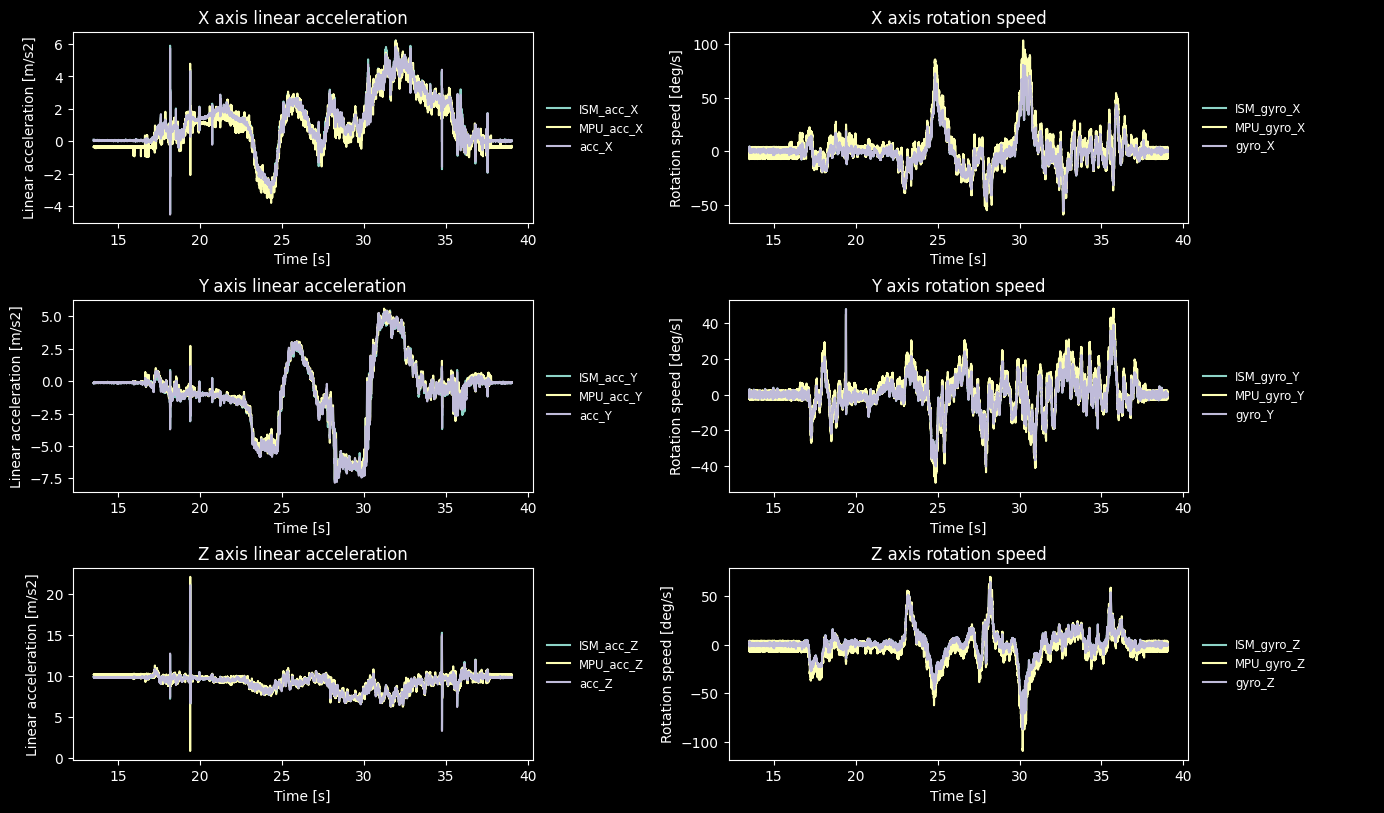

In [20]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot
axis[0, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_X_b'], label='ISM_acc_X')
axis[0, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_X_b'], label='MPU_acc_X')
axis[0, 0].plot(data_joined['time_rel'], data_joined['acc_X_t'], label='acc_X')
axis[0, 0].set_title('X axis linear acceleration')
axis[0, 0].set_xlabel('Time [s]')
axis[0, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")


# Second plot
axis[0, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_X_b'], label='ISM_gyro_X')
axis[0, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_X_b'], label='MPU_gyro_X')
axis[0, 2].plot(data_joined['time_rel'], data_joined['gyro_X_b'], label='gyro_X')
axis[0, 2].set_title('X axis rotation speed')
axis[0, 2].set_xlabel('Time [s]')
axis[0, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot 
axis[1, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Y_b'], label='ISM_acc_Y')
axis[1, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Y_b'], label='MPU_acc_Y')
axis[1, 0].plot(data_joined['time_rel'], data_joined['acc_Y_t'], label='acc_Y')
axis[1, 0].set_title('Y axis linear acceleration')
axis[1, 0].set_xlabel('Time [s]')
axis[1, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot
axis[1, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Y_b'], label='ISM_gyro_Y')
axis[1, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Y_b'], label='MPU_gyro_Y')
axis[1, 2].plot(data_joined['time_rel'], data_joined['gyro_Y_b'], label='gyro_Y')
axis[1, 2].set_title('Y axis rotation speed')
axis[1, 2].set_xlabel('Time [s]')
axis[1, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot
axis[2, 0].plot(data_rot_ISM['time_rel'], data_rot_ISM['acc_Z_b'], label='ISM_acc_Z')
axis[2, 0].plot(data_rot_MPU['time_rel'], data_rot_MPU['acc_Z_b'], label='MPU_acc_Z')
axis[2, 0].plot(data_joined['time_rel'], data_joined['acc_Z_t'], label='acc_Z')
axis[2, 0].set_title('Z axis linear acceleration')
axis[2, 0].set_xlabel('Time [s]')
axis[2, 0].set_ylabel('Linear acceleration [m/s2]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot
axis[2, 2].plot(data_rot_ISM['time_rel'], data_rot_ISM['gyro_Z_b'], label='ISM_gyro_Z')
axis[2, 2].plot(data_rot_MPU['time_rel'], data_rot_MPU['gyro_Z_b'], label='MPU_gyro_Z')
axis[2, 2].plot(data_joined['time_rel'], data_joined['gyro_Z_b'], label='gyro_Z')
axis[2, 2].set_title('Z axis rotation speed')
axis[2, 2].set_xlabel('Time [s]')
axis[2, 2].set_ylabel('Rotation speed [deg/s]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")

figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)

In [21]:
translator = AngleCalculator()
kalman = KalmanFilter()
data = data_joined.copy()

In [22]:
data.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2022-05-14 12:12:35.508000+00:00,13.531875,0.089285,-0.119950,9.876359,-0.006232,-0.045017,2.637666,0.0,0.0,0.0,0.089066,-0.120171,9.876351
2022-05-14 12:12:35.509000+00:00,13.532486,0.027907,-0.130572,9.852641,-0.351149,-0.390757,0.274374,0.0,0.0,0.0,0.027893,-0.130602,9.852618
2022-05-14 12:12:35.510000+00:00,13.533402,0.050379,-0.114619,9.811907,0.780198,0.010682,0.581282,0.0,0.0,0.0,0.050383,-0.114652,9.811902
2022-05-14 12:12:35.511000+00:00,13.533961,0.056403,-0.115084,9.800704,4.176922,2.256466,3.404554,0.0,0.0,0.0,0.056622,-0.115460,9.800685
2022-05-14 12:12:35.512000+00:00,13.535873,0.008902,-0.138862,9.817268,-0.081406,3.039733,0.658493,0.0,0.0,0.0,0.008590,-0.138897,9.817039


In [23]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3):
    print(data.describe())
    

        time_rel    acc_X_b    acc_Y_b    acc_Z_b   gyro_X_b   gyro_Y_b  \
count  25493.000  25493.000  25493.000  25493.000  25493.000  25493.000   
mean      26.277      1.212     -0.860      9.229     -0.027     -0.330   
std        7.359      1.579      2.545      0.895     16.388      9.687   
min       13.532     -4.425     -7.740      3.512    -56.275    -40.407   
25%       19.904      0.050     -1.454      8.808     -7.024     -3.673   
50%       26.277      1.027     -0.517      9.565     -0.549     -0.053   
75%       32.650      2.071     -0.075      9.822      2.095      3.783   
max       39.023      6.221      5.449     21.158     80.462     47.973   

        gyro_Z_b  gyro_X_b_der  gyro_Y_b_der  gyro_Z_b_der    acc_X_t  \
count  25493.000     25493.000     2.549e+04     25493.000  25493.000   
mean       0.258        -0.003     2.600e-04        -0.003      1.196   
std       14.449        67.695     5.222e+01        52.620      1.559   
min      -87.257      -273.713  

In [24]:
#data = bias.apply_bias(data)
# calculate phi and theta from accelerometers data
data = translator.calculate_angles_1(data)

In [25]:
# apply "Kalman filter" to phi and theta calculations (also get psi as an integral)
data = kalman.apply_kalman(data, extra=True)

In [26]:
# rotate sensors accelerations from sensor frame to earths frame using quaternions
data = translator.rotate_acc(data)

In [27]:
# get points 3D
curve = SensorCurve3D()

fun_iter = 0

In [28]:
    # def set_input_tables(self, x_acc, y_acc, z_acc, times):
    #     self.x_acc_list = x_acc[:]
    #     self.y_acc_list = y_acc[:]
    #     self.z_acc_list = z_acc[:]
    #     self.time_list = times[:]
    #     pass

curve.set_input_tables(x_acc=data['acc_X_e'].to_list(),y_acc=data['acc_Y_e'].to_list(), z_acc=data['acc_Z_e'].to_list(), times=data['time_rel'].to_list())

#curve.fill_curve(data, 9.8159, None)
curve.fill_curve_from_input_tables(9.8159, None)

In [29]:
print(data.describe())

           time_rel       acc_X_b       acc_Y_b       acc_Z_b      gyro_X_b  \
count  25493.000000  25493.000000  25493.000000  25493.000000  25493.000000   
mean      26.277403      1.211936     -0.860463      9.229400     -0.026998   
std        7.359338      1.579340      2.544500      0.895058     16.388347   
min       13.531875     -4.424540     -7.740071      3.512387    -56.274979   
25%       19.904451      0.049619     -1.454213      8.807617     -7.023769   
50%       26.277487      1.026892     -0.516532      9.565119     -0.548703   
75%       32.650365      2.071231     -0.074794      9.822298      2.094555   
max       39.023435      6.221096      5.449144     21.157889     80.462310   

           gyro_Y_b      gyro_Z_b  gyro_X_b_der  gyro_Y_b_der  gyro_Z_b_der  \
count  25493.000000  25493.000000  25493.000000  25493.000000  25493.000000   
mean      -0.329592      0.258202     -0.003027      0.000260     -0.002644   
std        9.687123     14.448927     67.694920    

speed_corrections = {'x': curve.x_speed_last / 8000, 'y': curve.y_speed_last / 8000, 'z': curve.z_speed_last / 8000}
curve.fill_curve(data, 0.001, 9.8159, speed_corrections)

## Przyspieszenia w stosunku do ziemi

In [30]:
data[['acc_X_e','acc_Y_e','acc_Z_e']]

,acc_X_e,acc_Y_e,acc_Z_e
_time,,,
2022-05-14 12:12:35.508000+00:00,0.080329,-0.108380,9.876563
2022-05-14 12:12:35.509000+00:00,0.015290,-0.095033,9.853053
2022-05-14 12:12:35.510000+00:00,0.027458,-0.057598,9.812494
2022-05-14 12:12:35.511000+00:00,0.024095,-0.041798,9.801410
2022-05-14 12:12:35.512000+00:00,-0.016188,-0.044911,9.817909
...,...,...,...
2022-05-14 12:13:00.996000+00:00,-0.037906,0.001829,9.764900
2022-05-14 12:13:00.997000+00:00,-0.007625,0.000540,9.807287
2022-05-14 12:13:00.998000+00:00,-0.007029,0.032410,9.845433


In [31]:
(data['acc_X_e']**2+data['acc_Y_e']**2+data['acc_Z_e']**2)**0.5

_time
2022-05-14 12:12:35.508000+00:00    9.877484
2022-05-14 12:12:35.509000+00:00    9.853523
2022-05-14 12:12:35.510000+00:00    9.812701
2022-05-14 12:12:35.511000+00:00    9.801528
2022-05-14 12:12:35.512000+00:00    9.818025
                                      ...   
2022-05-14 12:13:00.996000+00:00    9.764974
2022-05-14 12:13:00.997000+00:00    9.807290
2022-05-14 12:13:00.998000+00:00    9.845489
2022-05-14 12:13:00.999000+00:00    9.868315
2022-05-14 12:13:01+00:00           9.858658
Length: 25493, dtype: float64

In [32]:
### Przyspieszenia RAW 

In [33]:
data_raw_ISM[['acc_X','acc_Y','acc_Z']]

,acc_X,acc_Y,acc_Z
_time,,,
2022-05-14 12:12:35.508000+00:00,-9.857229,-0.227456,0.165205
2022-05-14 12:12:35.509000+00:00,-9.833286,-0.238230,0.102954
2022-05-14 12:12:35.510000+00:00,-9.792105,-0.222189,0.125460
2022-05-14 12:12:35.511000+00:00,-9.780612,-0.222668,0.131685
2022-05-14 12:12:35.512000+00:00,-9.797372,-0.246610,0.083800
...,...,...,...
2022-05-14 12:13:00.996000+00:00,-9.743501,-0.229850,0.064645
2022-05-14 12:13:00.997000+00:00,-9.786427,-0.234981,0.090640
2022-05-14 12:13:00.998000+00:00,-9.825625,-0.188669,0.093377


In [34]:
(data_raw_ISM['acc_X']**2+data_raw_ISM['acc_Y']**2+data_raw_ISM['acc_Z']**2)**0.5

_time
2022-05-14 12:12:35.508000+00:00    9.861237
2022-05-14 12:12:35.509000+00:00    9.836710
2022-05-14 12:12:35.510000+00:00    9.795429
2022-05-14 12:12:35.511000+00:00    9.784033
2022-05-14 12:12:35.512000+00:00    9.800834
                                      ...   
2022-05-14 12:13:00.996000+00:00    9.746426
2022-05-14 12:13:00.997000+00:00    9.789667
2022-05-14 12:13:00.998000+00:00    9.827879
2022-05-14 12:13:00.999000+00:00    9.851421
2022-05-14 12:13:01+00:00           9.841414
Length: 25493, dtype: float64

In [36]:
data_raw_MPU[['acc_X','acc_Y','acc_Z']]

,acc_X,acc_Y,acc_Z
_time,,,
2022-05-14 12:12:35.508000+00:00,4.905869,-4.740664,-7.862798
2022-05-14 12:12:35.509000+00:00,4.905869,-4.744255,-7.847235
2022-05-14 12:12:35.510000+00:00,4.905869,-4.758621,-7.823293
2022-05-14 12:12:35.511000+00:00,4.905869,-4.759818,-7.842447
2022-05-14 12:12:35.512000+00:00,4.905869,-4.743058,-7.858010
...,...,...,...
2022-05-14 12:13:00.996000+00:00,4.905869,-4.743058,-7.872375
2022-05-14 12:13:00.997000+00:00,4.905869,-4.800521,-7.814913
2022-05-14 12:13:00.998000+00:00,4.905869,-4.814886,-7.805336


In [37]:
(data_raw_MPU['acc_X']**2+data_raw_MPU['acc_Y']**2+data_raw_MPU['acc_Z']**2)**0.5

_time
2022-05-14 12:12:35.508000+00:00    10.409853
2022-05-14 12:12:35.509000+00:00    10.399741
2022-05-14 12:12:35.510000+00:00    10.388259
2022-05-14 12:12:35.511000+00:00    10.403239
2022-05-14 12:12:35.512000+00:00    10.407328
                                      ...    
2022-05-14 12:13:00.996000+00:00    10.418179
2022-05-14 12:13:00.997000+00:00    10.401222
2022-05-14 12:13:00.998000+00:00    10.400670
2022-05-14 12:13:00.999000+00:00    10.427533
2022-05-14 12:13:01+00:00           10.450465
Length: 25493, dtype: float64

In [38]:
### Przyspieszenia bias

In [39]:
data_bias_ISM[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2022-05-14 12:12:35.508000+00:00,-9.873893,-0.119979,0.093721
2022-05-14 12:12:35.509000+00:00,-9.850028,-0.130733,0.031603
2022-05-14 12:12:35.510000+00:00,-9.808982,-0.114722,0.054061
2022-05-14 12:12:35.511000+00:00,-9.797527,-0.115200,0.060273
2022-05-14 12:12:35.512000+00:00,-9.814232,-0.139097,0.012489
...,...,...,...
2022-05-14 12:13:00.996000+00:00,-9.760537,-0.122369,-0.006624
2022-05-14 12:13:00.997000+00:00,-9.803323,-0.127490,0.019316
2022-05-14 12:13:00.998000+00:00,-9.842392,-0.081267,0.022046


In [40]:
(data_bias_ISM['acc_X_b']**2+data_bias_ISM['acc_Y_b']**2+data_bias_ISM['acc_Z_b']**2)**0.5

_time
2022-05-14 12:12:35.508000+00:00    9.875066
2022-05-14 12:12:35.509000+00:00    9.850947
2022-05-14 12:12:35.510000+00:00    9.809802
2022-05-14 12:12:35.511000+00:00    9.798390
2022-05-14 12:12:35.512000+00:00    9.815225
                                      ...   
2022-05-14 12:13:00.996000+00:00    9.761307
2022-05-14 12:13:00.997000+00:00    9.804170
2022-05-14 12:13:00.998000+00:00    9.842752
2022-05-14 12:13:00.999000+00:00    9.865571
2022-05-14 12:13:01+00:00           9.855646
Length: 25493, dtype: float64

In [41]:
data_bias_MPU[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2022-05-14 12:12:35.508000+00:00,4.967075,-4.801578,-7.408611
2022-05-14 12:12:35.509000+00:00,4.967075,-4.805182,-7.393248
2022-05-14 12:12:35.510000+00:00,4.967075,-4.819597,-7.369614
2022-05-14 12:12:35.511000+00:00,4.967075,-4.820798,-7.388522
2022-05-14 12:12:35.512000+00:00,4.967075,-4.803980,-7.403884
...,...,...,...
2022-05-14 12:13:00.996000+00:00,4.967075,-4.803980,-7.418064
2022-05-14 12:13:00.997000+00:00,4.967075,-4.861642,-7.361342
2022-05-14 12:13:00.998000+00:00,4.967075,-4.876057,-7.351889


In [42]:
(data_bias_MPU['acc_X_b']**2+data_bias_MPU['acc_Y_b']**2+data_bias_MPU['acc_Z_b']**2)**0.5

_time
2022-05-14 12:12:35.508000+00:00    10.129881
2022-05-14 12:12:35.509000+00:00    10.120362
2022-05-14 12:12:35.510000+00:00    10.109974
2022-05-14 12:12:35.511000+00:00    10.124336
2022-05-14 12:12:35.512000+00:00    10.127564
                                      ...    
2022-05-14 12:13:00.996000+00:00    10.137936
2022-05-14 12:13:00.997000+00:00    10.124068
2022-05-14 12:13:00.998000+00:00    10.124131
2022-05-14 12:13:00.999000+00:00    10.149303
2022-05-14 12:13:01+00:00           10.170054
Length: 25493, dtype: float64

In [43]:
### Przyspieszenia Rotacja

In [44]:
data_rot_ISM[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2022-05-14 12:12:35.508000+00:00,0.093721,-0.119979,9.873893
2022-05-14 12:12:35.509000+00:00,0.031603,-0.130733,9.850028
2022-05-14 12:12:35.510000+00:00,0.054061,-0.114722,9.808982
2022-05-14 12:12:35.511000+00:00,0.060273,-0.115200,9.797527
2022-05-14 12:12:35.512000+00:00,0.012489,-0.139097,9.814232
...,...,...,...
2022-05-14 12:13:00.996000+00:00,-0.006624,-0.122369,9.760537
2022-05-14 12:13:00.997000+00:00,0.019316,-0.127490,9.803323
2022-05-14 12:13:00.998000+00:00,0.022046,-0.081267,9.842392


In [45]:
(data_rot_ISM['acc_X_b']**2+data_rot_ISM['acc_Y_b']**2+data_rot_ISM['acc_Z_b']**2)**0.5

_time
2022-05-14 12:12:35.508000+00:00    9.875066
2022-05-14 12:12:35.509000+00:00    9.850947
2022-05-14 12:12:35.510000+00:00    9.809802
2022-05-14 12:12:35.511000+00:00    9.798390
2022-05-14 12:12:35.512000+00:00    9.815225
                                      ...   
2022-05-14 12:13:00.996000+00:00    9.761307
2022-05-14 12:13:00.997000+00:00    9.804170
2022-05-14 12:13:00.998000+00:00    9.842752
2022-05-14 12:13:00.999000+00:00    9.865571
2022-05-14 12:13:01+00:00           9.855646
Length: 25493, dtype: float64

In [46]:
data_rot_MPU[['acc_X_b','acc_Y_b','acc_Z_b']]

,acc_X_b,acc_Y_b,acc_Z_b
_time,,,
2022-05-14 12:12:35.508000+00:00,-0.354352,-0.117024,10.123005
2022-05-14 12:12:35.509000+00:00,-0.341688,-0.114476,10.113944
2022-05-14 12:12:35.510000+00:00,-0.317768,-0.104283,10.104440
2022-05-14 12:12:35.511000+00:00,-0.330537,-0.103433,10.118410
2022-05-14 12:12:35.512000+00:00,-0.349809,-0.115325,10.120864
...,...,...,...
2022-05-14 12:13:00.996000+00:00,-0.359836,-0.115325,10.130891
2022-05-14 12:13:00.997000+00:00,-0.290897,-0.074553,10.119613
2022-05-14 12:13:00.998000+00:00,-0.277004,-0.064360,10.120136


In [47]:
(data_rot_MPU['acc_X_b']**2+data_rot_MPU['acc_Y_b']**2+data_rot_MPU['acc_Z_b']**2)**0.5

_time
2022-05-14 12:12:35.508000+00:00    10.129881
2022-05-14 12:12:35.509000+00:00    10.120362
2022-05-14 12:12:35.510000+00:00    10.109974
2022-05-14 12:12:35.511000+00:00    10.124336
2022-05-14 12:12:35.512000+00:00    10.127564
                                      ...    
2022-05-14 12:13:00.996000+00:00    10.137936
2022-05-14 12:13:00.997000+00:00    10.124068
2022-05-14 12:13:00.998000+00:00    10.124131
2022-05-14 12:13:00.999000+00:00    10.149303
2022-05-14 12:13:01+00:00           10.170054
Length: 25493, dtype: float64

In [48]:
def opt_iteration(bias_tab):
    global fun_iter
    global data
    global data_joined
    global curve
    global translator
    #global kalman
    fun_iter += 1

    print('Func_call: ', fun_iter)
    print('Input: ', bias_tab)
    # apply new bias to input data
    #bias.change_bias_acc_linear(bias_tab[0], bias_tab[1], bias_tab[2], bias_tab[3], bias_tab[4], bias_tab[5])
    # bias.change_bias_gyro_const(bias_tab[3], bias_tab[4], bias_tab[5])
    # g_temp= bias_tab[6]
    g_temp = 9.8159
    data['acc_X_t'] = data_joined['acc_X_t'] + bias_tab[0]
    data['acc_Y_t'] = data_joined['acc_Y_t'] + bias_tab[1]
    data['acc_Z_t'] = data_joined['acc_Z_t'] + bias_tab[2]
    #bias.apply_bias(data)
    # recalculate Kalman
    #data = translator.calculate_angles_1(data)
    #data = kalman.apply_kalman(data)
    #print(data.describe())
    #print('0')
    data = translator.rotate_acc(data)
    #print('1')
    curve.set_input_tables(x_acc=data['acc_X_e'].to_list(),y_acc=data['acc_Y_e'].to_list(), z_acc=data['acc_Z_e'].to_list(), times=data['time_rel'].to_list())
    curve.fill_curve_from_input_tables(9.8159, None)
    #curve.fill_curve(data, g_temp,None)
    #print('2')
    speed_arg = curve.x_speed_last ** 2 + curve.y_speed_last ** 2 + curve.z_speed_last ** 2
    #print('3')
    pos_arg = curve.x_point_last ** 2 + curve.y_point_last ** 2 + curve.z_point_last ** 2
    #deg_arg = kalman.psi_hat ** 2
    #acc_arg = (curve.acc_last - 9.8159) ** 2
    out = speed_arg + pos_arg #+ acc_arg * 10000  + pos_arg# + deg_arg
    print('Output: ', out, ' dx: ', curve.x_speed_last)
    return out

In [49]:
# run single opt iteration
#x_0 = array([bias.bias_linear['a_x_acc'], bias.bias_linear['a_y_acc'], bias.bias_linear['a_z_acc'],
#                bias.bias_linear['b_x_acc'], bias.bias_linear['b_y_acc'], bias.bias_linear['b_z_acc']])
# x_0 = np.array([bias.bias_const['x_acc'], bias.bias_const['y_acc'], bias.bias_const['z_acc']])
#                bias.bias_const['x_gyro'], bias.bias_const['y_gyro'], bias.bias_const['z_gyro']])
x_0 = array([0.0,0.0,0.0])
# func = opt_iteration(x_0)
# print(func)
#data = data_joined.copy()
minimize(opt_iteration, x_0, method='L-BFGS-B', bounds=[(-0.1, 0.1), (-0.1, 0.1), (-0.1, 0.1)],tol=0.01,
        options={'eps': 0.01, 'iprint': 0, 'maxiter': 3})

# minimize(opt_iteration, x_0, method='L-BFGS-B',  # method='TNC',
#         bounds=[(0.98, 1.02), (0.98, 1.02), (0.98, 1.02), (-0.15, 0.15), (-0.15, 0.15), (-0.15, 0.15)],
#         options={'maxiter': 100, 'eps': 0.0001, 'ftol': 0.001})



Func_call:  1
Input:  [0. 0. 0.]
Output:  100.63556777474655  dx:  0.6258650268877453
Func_call:  2
Input:  [0.01 0.   0.  ]
Output:  144.56114977252682  dx:  0.8694184048191144
Func_call:  3
Input:  [0.   0.01 0.  ]
Output:  123.34018001083903  dx:  0.6507907263428083
Func_call:  4
Input:  [0.   0.   0.01]
Output:  161.71074751002385  dx:  0.5912953089686881
Func_call:  5
Input:  [-0.1 -0.1 -0.1]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10
Output:  2068.9025121301206  dx:  -1.7132285677857955
Func_call:  6
Input:  [-0.09 -0.1  -0.1 ]
Output:  1916.8104179655736  dx:  -1.4696751898544476
Func_call:  7
Input:  [-0.1  -0.09 -0.1 ]
Output:  1894.467012911611  dx:  -1.688302868330736
Func_call:  8
Input:  [-0.1  -0.1  -0.09]
Output:  1933.714783901954  dx:  -1.7477982857048606
Func_call:  9
Input:  [-0.01731923 -0.01731923 -0.01731923]
Output:  19.50867473594554  dx:  0.22075198995333456
Func_call:  10
Input:  [-0.007319

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 7.772376203241099
        x: [-2.250e-02 -1.132e-02 -3.123e-02]
      nit: 3
      jac: [-7.774e-01  2.920e-01  4.105e-01]
     nfev: 20
     njev: 5
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

    3      3      5      5     0     0   1.225D-01   7.772D+00

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


# Get dataframe from device 3d curve

In [50]:
curve_df = curve.return_as_df()
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(curve_df.head())

                   X_p_e      Y_p_e      Z_p_e
mean_time_rel                                 
13.532         0.000e+00  0.000e+00  0.000e+00
13.532         4.729e-09 -2.111e-08  5.167e-09
13.533         1.846e-08 -1.213e-07  1.885e-08
13.534         2.707e-08 -2.143e-07  2.137e-08
13.536         2.454e-08 -6.660e-07 -3.630e-08


In [52]:
data.set_index('time_rel', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data.describe())

         acc_X_b    acc_Y_b    acc_Z_b   gyro_X_b   gyro_Y_b   gyro_Z_b  \
count  25493.000  25493.000  25493.000  25493.000  25493.000  25493.000   
mean       1.212     -0.860      9.229     -0.027     -0.330      0.258   
std        1.579      2.545      0.895     16.388      9.687     14.449   
min       -4.425     -7.740      3.512    -56.275    -40.407    -87.257   
25%        0.050     -1.454      8.808     -7.024     -3.673     -2.139   
50%        1.027     -0.517      9.565     -0.549     -0.053      0.319   
75%        2.071     -0.075      9.822      2.095      3.783      5.172   
max        6.221      5.449     21.158     80.462     47.973     64.591   

       gyro_X_b_der  gyro_Y_b_der  gyro_Z_b_der    acc_X_t    acc_Y_t  \
count     25493.000     2.549e+04     25493.000  25493.000  25493.000   
mean         -0.003     2.600e-04        -0.003      1.174     -0.887   
std          67.695     5.222e+01        52.620      1.559      2.610   
min        -273.713    -1.653e+0

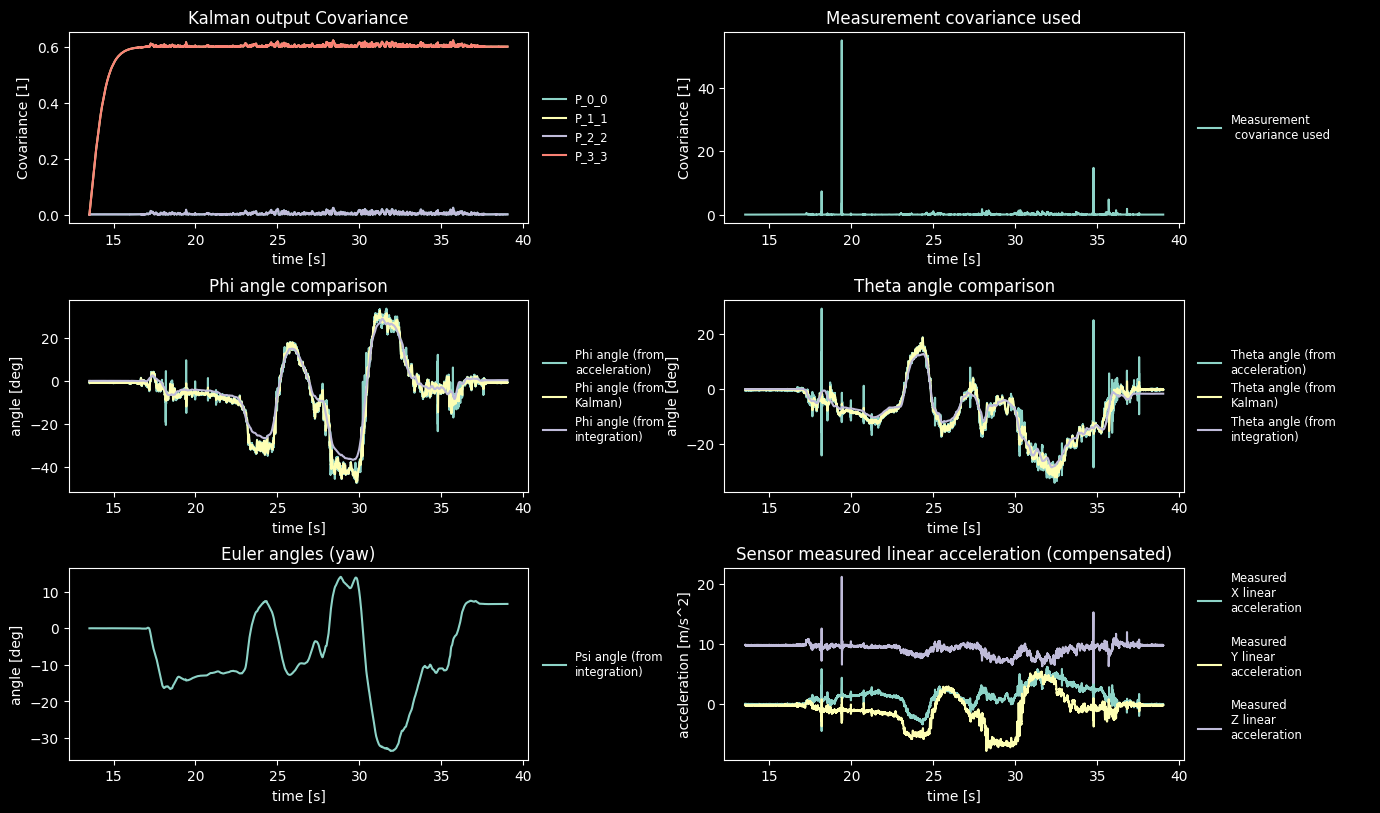

In [54]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Output estimate covariance
axis[0, 0].plot(data.index, data['P_0_0'], label='P_0_0')
axis[0, 0].plot(data.index, data['P_1_1'], label='P_1_1')
axis[0, 0].plot(data.index, data['P_2_2'], label='P_2_2')
axis[0, 0].plot(data.index, data['P_3_3'], label='P_3_3')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Kalman output Covariance')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['R'], label='Measurement\n covariance used')
axis[0, 2].set_title('Measurement covariance used')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('Covariance [1]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Phi angle
axis[1, 0].plot(data.index, data['acc_phi'] * 180 / pi, label='Phi angle (from\nacceleration)')
axis[1, 0].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 0].plot(data.index, data['int_phi'] * 180 / pi, label='Phi angle (from\nintegration)')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Phi angle comparison')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Theta angle
axis[1, 2].plot(data.index, data['acc_theta'] * 180 / pi, label='Theta angle (from\nacceleration)')
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['int_theta'] * 180 / pi, label='Theta angle (from\nintegration)')
axis[1, 2].set_title('Theta angle comparison')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Psi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot - Raw sensor acceleration data + bias compensation
axis[2, 2].plot(data.index, data['acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[2, 2].plot(data.index, data['acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[2, 2].plot(data.index, data['acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[2, 2].set_title('Sensor measured linear acceleration (compensated)')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


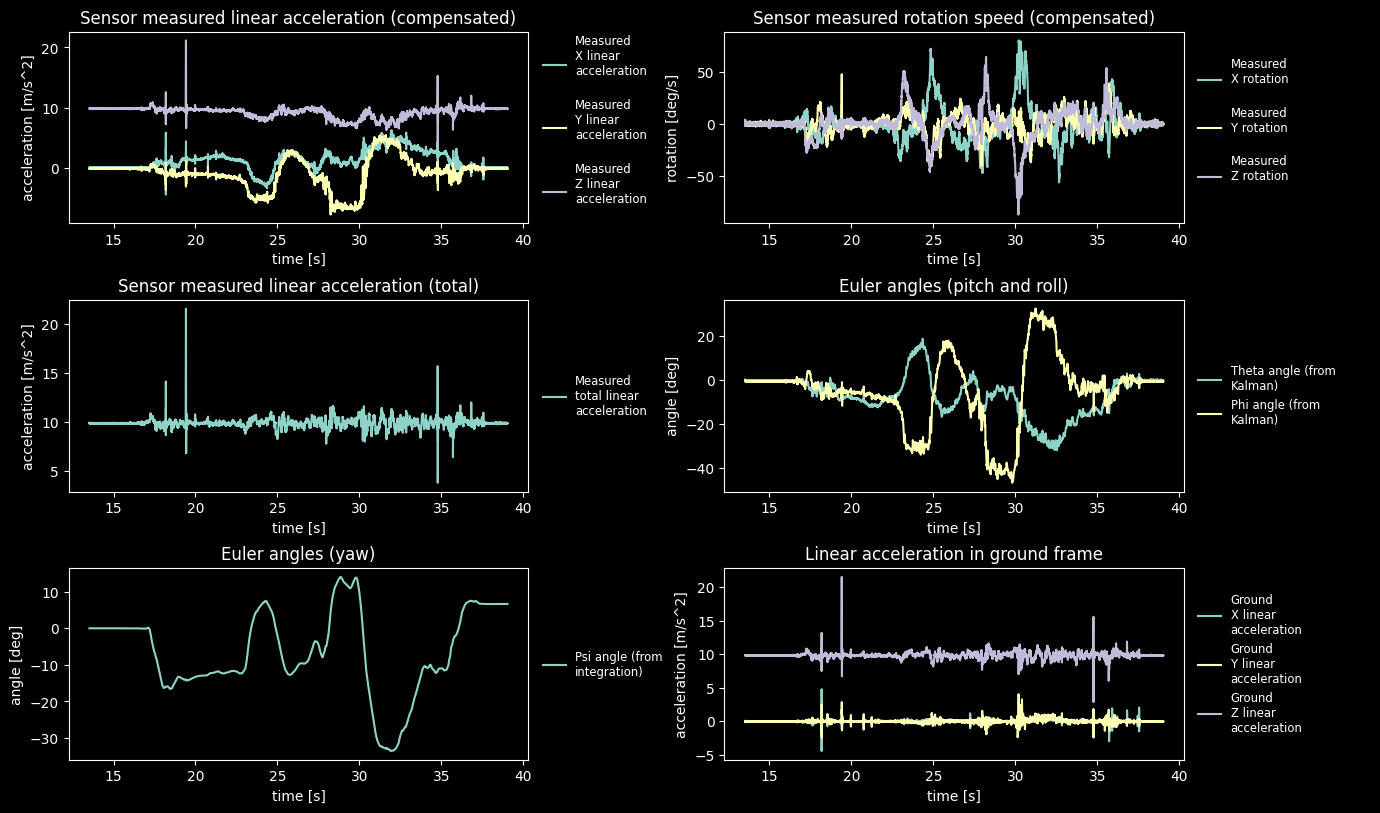

In [55]:
# Use dark theme for plots
plt.style.use('dark_background')

# Set up plot figure (canvas)
figure, axis = plt.subplots(3, 4,figsize=(14,8),gridspec_kw={'width_ratios': [2.6, 1,2.6,1]})

# First plot - Raw sensor acceleration data + bias compensation
axis[0, 0].plot(data.index, data['acc_X_b'], label='Measured\nX linear\nacceleration\n')
axis[0, 0].plot(data.index, data['acc_Y_b'], label='Measured\nY linear\nacceleration\n')
axis[0, 0].plot(data.index, data['acc_Z_b'], label='Measured\nZ linear\nacceleration\n')
#axis[0, 0].plot(data.index, data['mean_acc_X'], label='sensor X raw')
#axis[0, 0].plot(data.index, data['mean_acc_Y'], label='sensor Y raw')
#axis[0, 0].plot(data.index, data['mean_acc_Z'], label='sensor Z raw')
axis[0, 0].set_title('Sensor measured linear acceleration (compensated)')
axis[0, 0].set_xlabel('time [s]')
axis[0, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_0_0,l_0_0 = axis[0,0].get_legend_handles_labels()
axis[0,1].legend(h_0_0,l_0_0,borderaxespad=0, mode='expand', loc='center', fontsize='small',frameon=False)
axis[0,1].axis("tight")
axis[0,1].axis("off")



# Second plot - Gyroscope data
axis[0, 2].plot(data.index, data['gyro_X_b'], label='Measured\nX rotation\n')
axis[0, 2].plot(data.index, data['gyro_Y_b'], label='Measured\nY rotation\n')
axis[0, 2].plot(data.index, data['gyro_Z_b'], label='Measured\nZ rotation\n')
axis[0, 2].set_title('Sensor measured rotation speed (compensated)')
axis[0, 2].set_xlabel('time [s]')
axis[0, 2].set_ylabel('rotation [deg/s]')
# Set legend next to plot
h_0_2,l_0_2 = axis[0,2].get_legend_handles_labels()
axis[0,3].legend(h_0_2,l_0_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[0,3].axis("tight")
axis[0,3].axis("off")


# Third plot - Total acceleration (for checking whwther if translations work)
axis[1, 0].plot(data.index, data['g_sensor'], label='Measured\ntotal linear\nacceleration')
#axis[1, 0].plot(data.index, data['g_ground'], label='ground acceleration')
axis[1, 0].set_title('Sensor measured linear acceleration (total)')
axis[1, 0].set_xlabel('time [s]')
axis[1, 0].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_1_0,l_1_0 = axis[1,0].get_legend_handles_labels()
axis[1,1].legend(h_1_0,l_1_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,1].axis("tight")
axis[1,1].axis("off")


# Fourth plot - Kalman angular input, output
axis[1, 2].plot(data.index, data['theta_hat'] * 180 / pi, label='Theta angle (from\nKalman)')
axis[1, 2].plot(data.index, data['phi_hat'] * 180 / pi, label='Phi angle (from\nKalman)')
axis[1, 2].set_title('Euler angles (pitch and roll)')
axis[1, 2].set_xlabel('time [s]')
axis[1, 2].set_ylabel('angle [deg]')
# Set legend next to plot
h_1_2,l_1_2 = axis[1,2].get_legend_handles_labels()
axis[1,3].legend(h_1_2,l_1_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[1,3].axis("tight")
axis[1,3].axis("off")


#Fifth plot - Phi angle from acceleration integration
axis[2, 0].plot(data.index, data['psi_hat'] * 180 / pi, label='Psi angle (from\nintegration)')
axis[2, 0].set_title('Euler angles (yaw)')
axis[2, 0].set_xlabel('time [s]')
axis[2, 0].set_ylabel('angle [deg]')
# Set legend next to plot
h_2_0,l_2_0 = axis[2,0].get_legend_handles_labels()
axis[2,1].legend(h_2_0,l_2_0,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,1].axis("tight")
axis[2,1].axis("off")


# Sixth plot ground frame linear acceleration
axis[2, 2].plot(data.index, data['acc_X_e'], label='Ground\nX linear\nacceleration')
axis[2, 2].plot(data.index, data['acc_Y_e'], label='Ground\nY linear\nacceleration')
# axis[2, 1].plot(data.index, data['acc_Z_e'] - 9.8159, label='ground Z')
axis[2, 2].plot(data.index, data['acc_Z_e'], label='Ground\nZ linear\nacceleration')
axis[2, 2].set_title('Linear acceleration in ground frame')
axis[2, 2].set_xlabel('time [s]')
axis[2, 2].set_ylabel('acceleration [m/s^2]')
# Set legend next to plot
h_2_2,l_2_2 = axis[2,2].get_legend_handles_labels()
axis[2,3].legend(h_2_2,l_2_2,borderaxespad=0, loc='center left', fontsize='small',frameon=False)
axis[2,3].axis("tight")
axis[2,3].axis("off")
figure.subplots_adjust(left=0.05,
                    bottom=0.06, 
                    right=0.98, 
                    top=0.97, 
                    wspace=0.03, 
                    hspace=0.4)
#plt.subplot_tool()
#figure.tight_layout(pad=0.1, w_pad=0, h_pad=0.01)


Text(0.5, 0, 'position Z [m]')

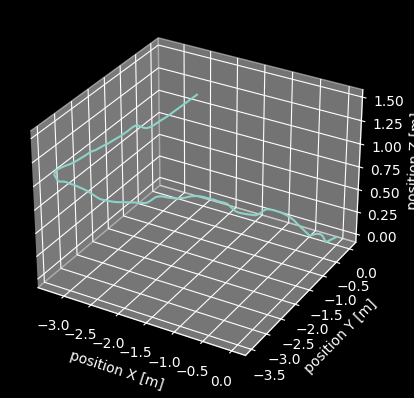

In [56]:
ax1 = plt.figure().add_subplot(projection='3d')
ax1.plot(curve.x_point_list, curve.y_point_list, curve.z_point_list, label='position curve')
ax1.set_xlabel('position X [m]')
ax1.set_ylabel('position Y [m]')
ax1.set_zlabel('position Z [m]')

Text(0.5, 0, 'speed Z [m/s]')

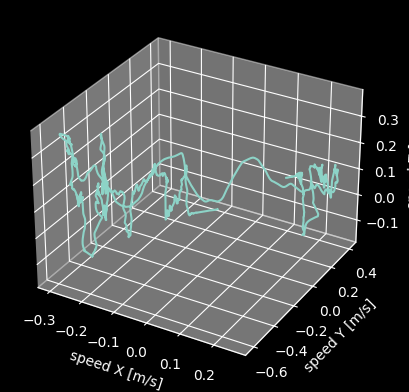

In [57]:
ax2 = plt.figure().add_subplot(projection='3d')
ax2.plot(curve.x_speed_list, curve.y_speed_list, curve.z_speed_list, label='speed curve')
ax2.set_xlabel('speed X [m/s]')
ax2.set_ylabel('speed Y [m/s]')
ax2.set_zlabel('speed Z [m/s]')
# data.to_csv('output.csv')

# print('Lack of testing code')

# Adding scanner points to path

## Get points data from database

In [68]:
data_scanner=db_client.get_scanner_data('scan_sensor_test', time_start, time_stop).dropna()

In [69]:
data_scanner.head()

,point_X,points_Z,time_rel
_time,,,
2022-05-14 12:12:41.484740+00:00,-41.587524,62.960815,19.508643
2022-05-14 12:12:41.484741+00:00,-41.460938,62.960815,19.508643
2022-05-14 12:12:41.484742+00:00,-41.326904,62.951660,19.508643
2022-05-14 12:12:41.484743+00:00,-41.192871,62.915039,19.508643
2022-05-14 12:12:41.484744+00:00,-41.066284,62.915039,19.508643


In [70]:
    with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                           'display.precision', 6,
                           ):
        print(data_scanner.describe())

             point_X       points_Z       time_rel
count  328180.000000  328180.000000  328180.000000
mean        1.490031      48.167767      22.503650
std        22.057280      22.352594       1.985438
min       -50.873047       8.432007      19.508643
25%       -15.503174      30.880737      20.712631
50%         2.137085      43.643188      22.232425
75%        18.928467      60.461426      24.349306
max        48.423218     122.982788      25.919695


In [71]:
# Set time as index
data_scanner.set_index('time_rel', inplace=True)
# Change index column name for it to be compatible with other data
# data_scanner.index.names=['time_rel']

### Interpolate device information for data points 

In [72]:
# Copy scanner data
index_tmp_df = data_scanner.copy()

# Leave only indexes without duplicates
index_tmp_df=index_tmp_df[~index_tmp_df.index.duplicated(keep='first')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                        'display.precision', 6,
                        ):
    print(index_tmp_df.describe())

          point_X    points_Z
count  651.000000  651.000000
mean   -39.598656   72.421841
std      9.684871   28.630901
min    -50.873047   14.721680
25%    -44.953247   60.749817
50%    -41.773682   68.847656
75%    -34.997559  101.234436
max     25.622681  122.982788


In [73]:
# Drop points columns to leave only 
index_tmp_df=index_tmp_df.drop(columns=['point_X','points_Z'])

In [74]:
len(index_tmp_df)

651

In [75]:
interpolation_df= pd.concat([index_tmp_df, data[['theta_hat','phi_hat','psi_hat']]], ignore_index=False, join='outer')
interpolation_df.sort_index(inplace=True)
interpolation_df.interpolate(inplace=True)

In [76]:
index_tmp_df.index

Index([ 19.50864315032959, 19.519514083862305,  19.52125597000122,
       19.522505044937134, 19.523771047592163, 19.525057077407837,
       19.526307106018066,  19.52762508392334,   19.5294930934906,
       19.530987977981567,
       ...
       25.830069065093994, 25.839250087738037, 25.849568128585815,
       25.859391927719116, 25.869372129440308, 25.879420042037964,
        25.88944697380066, 25.899425983428955, 25.909470081329346,
       25.919695138931274],
      dtype='float64', name='time_rel', length=651)

In [77]:
interpolated_angles = interpolation_df.loc[index_tmp_df.index.values]

In [81]:
interpolated_angles.head()

,theta_hat,phi_hat,psi_hat
time_rel,,,
19.508643,-0.144277,-0.067634,-0.247629
19.519514,-0.142231,-0.086314,-0.247245
19.521256,-0.141482,-0.088816,-0.247224
19.522505,-0.141035,-0.092723,-0.247195
19.523771,-0.140997,-0.094364,-0.247179


In [91]:
data_scanner_dev_frame.head()

,Z,Y,X
time_rel,,,
19.508643,-62.960815,41.587524,0.0
19.508643,-62.960815,41.460938,0.0
19.508643,-62.951660,41.326904,0.0
19.508643,-62.915039,41.192871,0.0
19.508643,-62.915039,41.066284,0.0


## Rotate scanner points vectors to device default frame

In [96]:
# Go from scanner frame coordinates, to device coordinates
data_scanner_dev_frame = pd.DataFrame()
data_scanner_dev_frame['Z']=-data_scanner['points_Z']
data_scanner_dev_frame['Y']=-data_scanner['point_X']
data_scanner_dev_frame['X']=0.0
# Add device euler angles
# data_scanner_dev_frame = pd.concat([interpolated_angles,data_scanner_dev_frame], axis = 1, join = 'inner')
data_scanner_dev_frame = data_scanner_dev_frame.join(interpolated_angles)

with pd.option_context('display.max_rows', None, 'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(data_scanner_dev_frame.head())

               Z       Y    X  theta_hat  phi_hat  psi_hat
time_rel                                                  
19.509   -62.961  41.588  0.0     -0.144   -0.068   -0.248
19.509   -62.961  41.461  0.0     -0.144   -0.068   -0.248
19.509   -62.952  41.327  0.0     -0.144   -0.068   -0.248
19.509   -62.915  41.193  0.0     -0.144   -0.068   -0.248
19.509   -62.915  41.066  0.0     -0.144   -0.068   -0.248


In [97]:
# Rotate point vectors with device euler angles in order to get global point translation vectors
points_translation = translator.rotate_vect(data_scanner_dev_frame)


In [98]:
print( points_translation)

                 X_e        Y_e        Z_e
time_rel                                  
19.508643  18.275025  33.788776 -64.945581
19.508643  18.242876  33.666633 -64.937115
19.508643  18.207715  33.538226 -64.919112
19.508643  18.169189  33.412585 -64.873990
19.508643  18.137040  33.290441 -64.865524
...              ...        ...        ...
25.919695  12.655558 -23.309565 -74.276243
25.919695  12.617212 -23.424152 -74.220101
25.919695  12.590547 -23.564812 -74.236671
25.919695  12.569944 -23.693816 -74.268010
25.919695  12.538220 -23.839093 -74.267599

[328180 rows x 3 columns]


## calculate points position in earth frame

In [99]:
# interpolate positions from curve

int_curve_df= pd.concat([index_tmp_df, curve_df], ignore_index=False, join='outer')
int_curve_df.sort_index(inplace=True)
int_curve_df.interpolate(inplace=True)
int_curve_df.head()

,X_p_e,Y_p_e,Z_p_e
13.531875,0.000000e+00,0.000000e+00,0.000000e+00
13.532486,4.728619e-09,-2.110586e-08,5.166870e-09
13.533402,1.846150e-08,-1.212994e-07,1.884656e-08
13.533961,2.707185e-08,-2.143471e-07,2.136505e-08
13.535873,2.453749e-08,-6.659629e-07,-3.630263e-08


In [100]:
interpolated_curve = int_curve_df.loc[index_tmp_df.index.values]
interpolated_curve.describe()

,X_p_e,Y_p_e,Z_p_e
count,651.000000,651.000000,651.000000
mean,-1.022196,-0.530161,0.220696
std,0.399143,0.316838,0.123298
min,-1.754589,-1.285313,-0.005260
25%,-1.369416,-0.717977,0.148575
50%,-0.986537,-0.437295,0.218842
75%,-0.664712,-0.262882,0.261305
max,-0.415905,-0.175683,0.501877


In [101]:
interpolated_curve.head()

,X_p_e,Y_p_e,Z_p_e
19.508643,-0.415905,-0.175683,-0.005260
19.519514,-0.417538,-0.176110,-0.004394
19.521256,-0.417693,-0.176151,-0.004311
19.522505,-0.417968,-0.176224,-0.004163
19.523771,-0.418120,-0.176265,-0.004081


### Calculate final points on curve

In [103]:
vects_and_curve = interpolated_curve.join(points_translation)
vects_and_curve.head()

,X_p_e,Y_p_e,Z_p_e,X_e,Y_e,Z_e
19.508643,-0.415905,-0.175683,-0.00526,18.275025,33.788776,-64.945581
19.508643,-0.415905,-0.175683,-0.00526,18.242876,33.666633,-64.937115
19.508643,-0.415905,-0.175683,-0.00526,18.207715,33.538226,-64.919112
19.508643,-0.415905,-0.175683,-0.00526,18.169189,33.412585,-64.873990
19.508643,-0.415905,-0.175683,-0.00526,18.137040,33.290441,-64.865524


In [104]:
final_points = pd.DataFrame()
final_points['X'] = vects_and_curve['X_p_e']+vects_and_curve['X_e']/1000
final_points['Y'] = vects_and_curve['Y_p_e']+vects_and_curve['Y_e']/1000
final_points['Z'] = vects_and_curve['Z_p_e']+vects_and_curve['Z_e']/1000


Text(0.5, 0, 'position Z [m]')

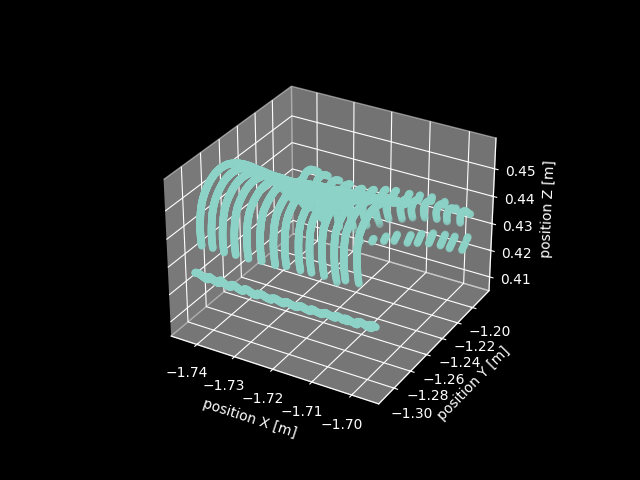

In [105]:
%matplotlib widget
ax3 = plt.figure().add_subplot(projection='3d')
ax3.scatter(final_points.tail(8000)['X'], final_points.tail(8000)['Y'], final_points.tail(8000)['Z'], label='points')
#ax3.set_xlim([-0.1,0.1])
#ax3.set_ylim([-2,-1])
#ax3.set_zlim([0.3,0.5])
ax3.set_xlabel('position X [m]')
ax3.set_ylabel('position Y [m]')
ax3.set_zlabel('position Z [m]')

### Reorganize data to make it usable in optimizer


In [107]:
# Input structure for device curve
#       input_structure = [{'mean_time_rel': 0.0,
#                          'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#                          'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#                          'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]}]
#                          scanner points must be in device frame as it won't change
from scipy.spatial.transform import Rotation


positions = []
for index in index_tmp_df.index:
    # 'mean_time_rel': 0.0,
    time_rel_in = index
    
    # 'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    pos_row = interpolated_curve.loc[index]
    dev_pos_in = {'X':pos_row['X_p_e'],'Y':pos_row['Y_p_e'],'Z':pos_row['Z_p_e']}
    
    # 'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    rot_row = interpolated_angles.loc[index]
    ang_names = ['psi_hat', 'theta_hat', 'phi_hat']
    rot = Rotation.from_euler('ZYX', [rot_row[ang_names[0]], rot_row[ang_names[1]], rot_row[ang_names[2]]], degrees=False)
    rot_vect = rot.as_rotvec()
    dev_rot_in = {'X':rot_vect[0],'Y':rot_vect[1],'Z':rot_vect[2]}
    
    # 'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]
    scanner_points_in = []
    for point in data_scanner_dev_frame.loc[index].iterrows():
        scanner_points_in.append({'X': point[1]['X']/1000, 'Y': point[1]['Y']/1000, 'Z': point[1]['Z']/1000})
        
    # input_structure list filling
    positions.append({'time_rel': index,
                      'dev_pos': dev_pos_in,
                      'dev_rot_vect': dev_rot_in,
                      'scanner_points': scanner_points_in.copy()})

# import json
# with open('/media/adamw/DATA/Projekty/Praca_mgr/scan_3d_MGR/gui_server/DataAnalysisClasses/test.json', 'w') as fout:
#     json.dump(positions , fout)


In [108]:
data_joined.head()

,time_rel,acc_X_b,acc_Y_b,acc_Z_b,gyro_X_b,gyro_Y_b,gyro_Z_b,gyro_X_b_der,gyro_Y_b_der,gyro_Z_b_der,acc_X_t,acc_Y_t,acc_Z_t
_time,,,,,,,,,,,,,
2022-05-14 12:12:35.508000+00:00,13.531875,0.089285,-0.119950,9.876359,-0.006232,-0.045017,2.637666,0.0,0.0,0.0,0.089066,-0.120171,9.876351
2022-05-14 12:12:35.509000+00:00,13.532486,0.027907,-0.130572,9.852641,-0.351149,-0.390757,0.274374,0.0,0.0,0.0,0.027893,-0.130602,9.852618
2022-05-14 12:12:35.510000+00:00,13.533402,0.050379,-0.114619,9.811907,0.780198,0.010682,0.581282,0.0,0.0,0.0,0.050383,-0.114652,9.811902
2022-05-14 12:12:35.511000+00:00,13.533961,0.056403,-0.115084,9.800704,4.176922,2.256466,3.404554,0.0,0.0,0.0,0.056622,-0.115460,9.800685
2022-05-14 12:12:35.512000+00:00,13.535873,0.008902,-0.138862,9.817268,-0.081406,3.039733,0.658493,0.0,0.0,0.0,0.008590,-0.138897,9.817039


In [109]:
data_joined.keys()

Index(['time_rel', 'acc_X_b', 'acc_Y_b', 'acc_Z_b', 'gyro_X_b', 'gyro_Y_b',
       'gyro_Z_b', 'gyro_X_b_der', 'gyro_Y_b_der', 'gyro_Z_b_der', 'acc_X_t',
       'acc_Y_t', 'acc_Z_t'],
      dtype='object')

In [110]:
cols_list = ['time_rel','gyro_X_b', 'gyro_Y_b', 'gyro_Z_b', 'acc_X_t','acc_Y_t', 'acc_Z_t']
cols_rename = {'gyro_X_b':'X_gyr',
               'gyro_Y_b':'Y_gyr',
               'gyro_Z_b':'Z_gyr',
               'acc_X_t':'X_acc',
               'acc_Y_t':'Y_acc',
               'acc_Z_t':'Z_acc'}
data_joined.loc[(data_joined['time_rel']>=14.1) &(data_joined['time_rel']<=14.11)][cols_list].copy().rename(columns = cols_rename).to_dict('records')

[{'time_rel': 14.100380341605385,
  'X_gyr': 0.09226586674176328,
  'Y_gyr': -0.23146906738925985,
  'Z_gyr': -0.4234538672099008,
  'X_acc': 0.0527927790954492,
  'Y_acc': -0.09077738291535421,
  'Z_acc': 9.818951138727426},
 {'time_rel': 14.10137429685876,
  'X_gyr': 0.9926671698206605,
  'Y_gyr': 0.015687889668971573,
  'Z_gyr': -0.12067699114275832,
  'X_acc': 0.036385312998943806,
  'Y_acc': -0.13944566000655328,
  'Z_acc': 9.809685559984324},
 {'time_rel': 14.10238020254834,
  'X_gyr': -0.694353813030207,
  'Y_gyr': -0.07767570452138274,
  'Z_gyr': -0.16182717745958922,
  'X_acc': 0.04039219882883254,
  'Y_acc': -0.11493988548495256,
  'Z_acc': 9.833969518319316},
 {'time_rel': 14.103294754972552,
  'X_gyr': 0.08729550581601529,
  'Y_gyr': -0.15098606748393115,
  'Z_gyr': -0.4133468842235092,
  'X_acc': 0.04444399421429427,
  'Y_acc': -0.09315701380332238,
  'Z_acc': 9.813881183558891},
 {'time_rel': 14.104449003049643,
  'X_gyr': -0.0721275126394325,
  'Y_gyr': -0.35812874527409

In [112]:
# Input structure for new device curve
# [{'mean_time_rel': 0.0,
#   'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_speed': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_euler_ang': {'psi': 0.0, 'theta': 0.0, 'phi': 0.0},
#   'imu_input':[{'mean_time_rel': 0.0,
#                 'X_acc': 0.0, 'Y_acc': 0.0, 'Z_acc': 0.0,
#                 'X_gyr': 0.0, 'Y_gyr': 0.0, 'Z_gyr': 0.0}],
#   'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]}]


cols_list = ['time_rel','gyro_X_b', 'gyro_Y_b', 'gyro_Z_b', 'acc_X_t','acc_Y_t', 'acc_Z_t']
cols_rename = {'gyro_X_b':'X_gyr',
               'gyro_Y_b':'Y_gyr',
               'gyro_Z_b':'Z_gyr',
               'acc_X_t':'X_acc',
               'acc_Y_t':'Y_acc',
               'acc_Z_t':'Z_acc'}


positions = []
prev_time = 0.0
min_time = data_joined['time_rel'].min()
for index in index_tmp_df.index:
    # 'mean_time_rel': 0.0,
    time_rel_in = index - min_time
    
    # 'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    dev_pos_in = None
    
    #'dev_speed': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    dev_speed_in = None
    
    # 'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0}
    dev_rot_in = None
    
    # 'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]
    scanner_points_in = []
    for point in data_scanner_dev_frame.loc[index].iterrows():
        scanner_points_in.append({'X': point[1]['X']/1000, 'Y': point[1]['Y']/1000, 'Z': point[1]['Z']/1000})
        
    # 'dev_euler_ang': {'psi': 0.0, 'theta': 0.0, 'phi': 0.0},
    dev_euler_ang_in = None
    
    # 'imu_input':[{'mean_time_rel': 0.0,
    #               'X_acc': 0.0, 'Y_acc': 0.0, 'Z_acc': 0.0,
    #               'X_gyr': 0.0, 'Y_gyr': 0.0, 'Z_gyr': 0.0}],
    imu_input_in = data_joined.loc[(
        data_joined['time_rel']>=prev_time) & (
        data_joined['time_rel']<index)][cols_list].copy().rename(columns = cols_rename).to_dict('records')
    
    for row in imu_input_in:
        row['time_rel'] = row['time_rel'] - min_time
    
    # input_structure list filling
    positions.append({'time_rel': time_rel_in,
                      'dev_pos': dev_pos_in,
                      'dev_speed': dev_speed_in,
                      'dev_rot_vect': dev_rot_in,
                      'dev_euler_ang': dev_euler_ang_in,
                      'imu_input': imu_input_in.copy(),
                      'scanner_points': scanner_points_in.copy()})
# [{'mean_time_rel': 0.0,
#   'dev_pos': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_speed': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_rot_vect': {'X': 0.0, 'Y': 0.0, 'Z': 0.0},
#   'dev_euler_ang': {'psi': 0.0, 'theta': 0.0, 'phi': 0.0},
#   'imu_input':[{'mean_time_rel': 0.0,
#                 'X_acc': 0.0, 'Y_acc': 0.0, 'Z_acc': 0.0,
#                 'X_gyr': 0.0, 'Y_gyr': 0.0, 'Z_gyr': 0.0}],
#   'scanner_points': [{'X': 0.0, 'Y': 0.0, 'Z': 0.0}]}]
    
    
    
    prev_time = index
    
    


In [113]:
if False:
    import json
    with open('/media/adamw/DATA/Projekty/Praca_mgr/scan_3d_MGR/gui_server/DataAnalysisClasses/test4.json', 'w') as fout:
        json.dump(positions , fout)

In [114]:
positions[1]

{'time_rel': 5.987639549935219,
 'dev_pos': None,
 'dev_speed': None,
 'dev_rot_vect': None,
 'dev_euler_ang': None,
 'imu_input': [{'time_rel': 5.977269777414081,
   'X_gyr': -0.7904139176661821,
   'Y_gyr': -0.8123740442759431,
   'Z_gyr': 1.8235921918788964,
   'X_acc': 1.4256022219552185,
   'Y_acc': -0.7459569066792581,
   'Z_acc': 9.866917705234478},
  {'time_rel': 5.97827150483336,
   'X_gyr': -0.3047974166199685,
   'Y_gyr': -0.5260539065653947,
   'Z_gyr': 1.8532102180288927,
   'X_acc': 1.425922833696021,
   'Y_acc': -0.7668679218337281,
   'Z_acc': 9.869117844359858},
  {'time_rel': 5.979269936882973,
   'X_gyr': 0.20267564891974518,
   'Y_gyr': -0.26975234008731896,
   'Z_gyr': 1.9055394299174426,
   'X_acc': 1.4257789898537345,
   'Y_acc': -0.7879442394464041,
   'Z_acc': 9.871025467390046},
  {'time_rel': 5.980271909802573,
   'X_gyr': 0.7226416422608252,
   'Y_gyr': -0.0319319580335048,
   'Z_gyr': 1.9675840505609379,
   'X_acc': 1.4263321622699987,
   'Y_acc': -0.809725

In [115]:
positions[0]['imu_input'][3000]

{'time_rel': 2.999577077701934,
 'X_gyr': 2.197534153472243,
 'Y_gyr': -1.4938321004995614,
 'Z_gyr': -1.517210480312079,
 'X_acc': 0.027741634172685662,
 'Y_acc': -0.15218256602802135,
 'Z_acc': 9.88335788056571}